# Simulation #

***Using python to simulate initial-value problems***


An "initial value problem" is a problem that is set by an equation that gives the rate of change of a variable or array $\boldsymbol{y}$ as a function of the time $t$ and the array itself:

$$ \frac{d \boldsymbol{y}}{dt} = F(t, \boldsymbol{y}) $$

for an arbitrary function or array of functions $F$. After providing an initial condition $\boldsymbol{y}_0 = \boldsymbol{y}(t=0)$, the solution at later times is completely determined.

Broadly speaking, even when an equation of this sort has no closed-form solution, numerical methods can easily handle these systems because the value of $\boldsymbol{y}$ at a later time $t+dt$ can be numerically extrapolated using the slope of $\boldsymbol{y}$ at the current time $t$. 

As an example, consider describing the motion of a damped, driven pendulum, which obeys the second-order differential equation

$$\ddot{\phi} +2\beta \dot{\phi} + \omega_0^2 \sin \phi = \gamma \omega_0^2 \cos \omega t$$

where the dot represents a time derivative, $\dot{\phi}\equiv\frac{d\phi}{dt}$.

We want to simulate this system.

To get this system into the form above, we define the $\boldsymbol{y}$ state vector (array) as the following:

$$\boldsymbol{y} = \begin{pmatrix} \phi \\ \dot{\phi} \end{pmatrix}$$

Then we can write:

$$ \frac{d\boldsymbol{y}}{dt} = \begin{pmatrix} \dot{\phi} \\ \gamma \omega_0^2 \cos \omega t - 2\beta \dot{\phi} - \omega_0^2 \sin \phi \end{pmatrix}$$

We've turned a single second-order differential equation into a set of two coupled first-order differential equations, which is exactly the type of equation we can solve numerically.

The function [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) takes a function $F(t,\boldsymbol{y})$ and integrates it from some initial condition $\boldsymbol{y}_0$.

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [305]:
rng = np.random.default_rng()

Define parameters. Here we'll use the stand-ins `p` for $\phi$, `dp` for $\dot{\phi}$, `w0` for $\omega_0$, `w` for $\omega$, `B` for $\beta$, and `Y` for $\gamma$:

In [306]:
# parameters
w0 = 1.5
B = 0.375
w = 1
Y = 1.1088

Define a function to return the first derivative of $\boldsymbol{y}$:

In [307]:
def func(t, y, w0, B, w, Y):
    p, dp = y # unpack array

    return np.array([
        dp, 
        Y*w0**2*np.cos(w*t) - 2*B*dp - w0**2*np.sin(p)
    ])

Define initial conditions and the time range and evaluation points (points in time where we want to know the position and velocity), `ts`

In [312]:
p0 = np.deg2rad(170)
dp0 = 0

y0 = np.array([p0, dp0])

tmax = 200

ts = np.linspace(0, tmax, 5000)

The `solve_ivp` function returns an object which we name `sol`. 

`sol.t` contains an array of $t$ values and `sol.y` contains the values of $\boldsymbol{y}$ at those times. Note that `sol.y[0]` contains the first row of $\boldsymbol{y}$ at all times, `sol.y[1]` the second row, etc.  

Text(0, 0.5, '$d\\phi/dt$')

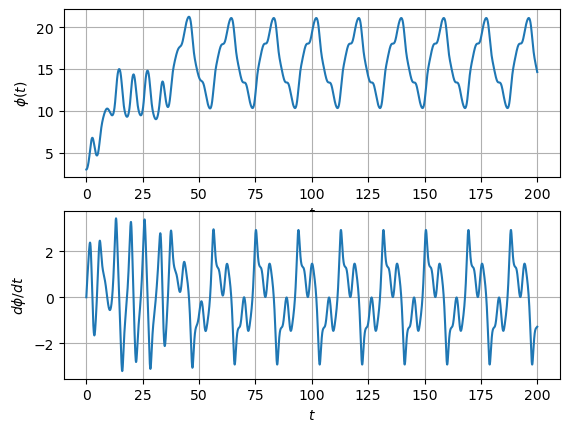

In [313]:
sol = solve_ivp(func, y0 = y0, t_span = (0, tmax), t_eval = ts, args = (w0, B, w, Y))

fix, axs = plt.subplots(nrows = 2, ncols = 1)
for ax in axs:
    ax.grid()
    ax.set_xlabel('$t$')

axs[0].plot(sol.t, sol.y[0])
axs[0].set_ylabel('$\\phi(t)$')

axs[1].plot(sol.t, sol.y[1])
axs[1].set_ylabel('$d\\phi/dt$')

If you play around with the initial condition, you'll notice that little changes can cause massive changes in the behavior (this is part of what we mean when we say that this system is *chaotic* for $\gamma=1.1$).

To qualitatively investigate this behavior, we can use the function `jitter()` defined below to add a bit of random variation to the initial position of the pendulum

In [318]:
def jitter():
    return np.array([rng.random(), 0])

Text(0, 0.5, '$\\phi(t)$')

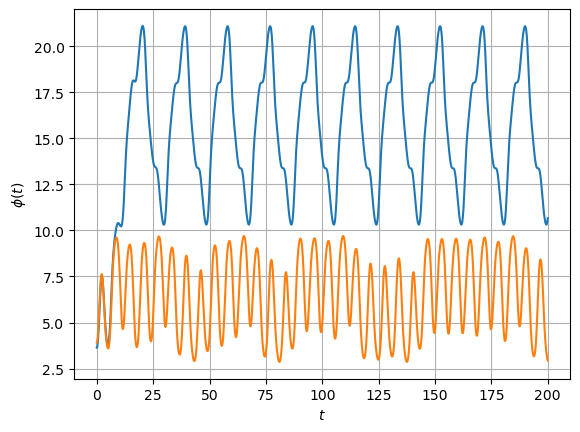

In [329]:
plt.figure()
plt.grid()
sol = solve_ivp(func, y0 = y0 + jitter(), t_span = (0, tmax), t_eval = ts, args = (w0, B, w, Y))
plt.plot(sol.t, sol.y[0])

sol = solve_ivp(func, y0 = y0 + jitter(), t_span = (0, tmax), t_eval = ts, args = (w0, B, w, Y))
plt.plot(sol.t, sol.y[0])

plt.xlabel('$t$')
plt.ylabel('$\\phi(t)$')

We can sweep nearby values of the starting condition above and see the wide range of behaviors we see.

First, let's create a colormap to try to visually organize the curves we're about to plot. This will require the base `matplotlib` module, not just `pyplot`

In [344]:
import matplotlib

Text(0, 0.5, '$\\phi(t)$')

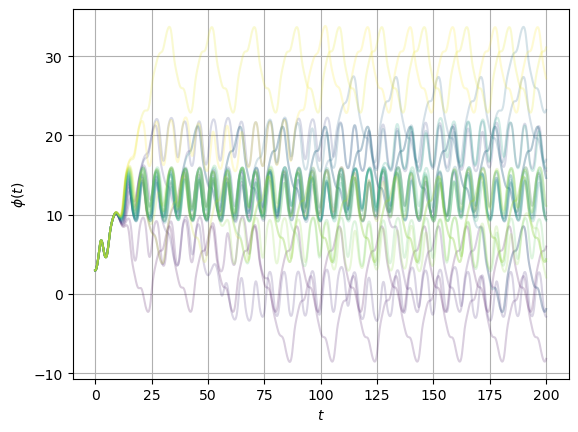

In [356]:
p0_sweep = np.linspace(-1, 1, 25)/1e2

norm = matplotlib.colors.Normalize(vmin = p0_sweep.min(), vmax = p0_sweep.max())
cmap = plt.get_cmap('viridis')

plt.figure()
plt.grid()
for delta_p0 in p0_sweep:
    sol = solve_ivp(func, y0 = y0 + np.array([delta_p0, 0]), t_span = (0, tmax), t_eval = ts, args = (w0, B, w, Y))

    plt.plot(sol.t, sol.y[0], color = cmap(norm(delta_p0)), alpha = 0.2)

plt.xlabel('$t$')
plt.ylabel('$\\phi(t)$')